In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras

In [2]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count = pd.DataFrame(getRegisteredUsersCount())

In [3]:
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
registration_date         30 non-null object
registered_users_count    30 non-null int64
dtypes: int64(1), object(1)
memory usage: 608.0+ bytes


In [4]:
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])

In [5]:
registered_users_count.head()

,registration_date,registered_users_count
0,2019-06-01,4833
1,2019-06-02,5255
2,2019-06-03,4193
3,2019-06-04,4194
4,2019-06-05,3998


In [6]:
registered_users_count['registered_users_count'].sum()

100423

In [7]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())

In [8]:
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 3 columns):
activity_date         930 non-null object
registration_date     930 non-null object
active_users_count    930 non-null int64
dtypes: int64(1), object(2)
memory usage: 21.9+ KB


In [9]:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])

In [10]:
active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-06-01,2019-06-01,1651
1,2019-06-02,2019-06-01,1429
2,2019-06-02,2019-06-02,1933
3,2019-06-03,2019-06-01,1021
4,2019-06-03,2019-06-02,1550


In [11]:
retention_table = active_users_count_with_cohorts.merge(registered_users_count, how = 'left', on = ['registration_date'])
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-06-01,2019-06-01,1651,4833
1,2019-06-02,2019-06-01,1429,4833
2,2019-06-02,2019-06-02,1933,5255
3,2019-06-03,2019-06-01,1021,4833
4,2019-06-03,2019-06-02,1550,5255


In [12]:
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count'] * 100
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-06-01,2019-06-01,1651,4833,34.160977
1,2019-06-02,2019-06-01,1429,4833,29.567556
2,2019-06-02,2019-06-02,1933,5255,36.784015
3,2019-06-03,2019-06-01,1021,4833,21.125595
4,2019-06-03,2019-06-02,1550,5255,29.495718


In [13]:
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-06-01,2019-06-01,1651,4833,34.160977,0 days
1,2019-06-02,2019-06-01,1429,4833,29.567556,1 days
2,2019-06-02,2019-06-02,1933,5255,36.784015,0 days
3,2019-06-03,2019-06-01,1021,4833,21.125595,2 days
4,2019-06-03,2019-06-02,1550,5255,29.495718,1 days


In [14]:
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int) # Приведем тип к целому числу

In [15]:
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-06-01,2019-06-01,1651,4833,34.160977,0
1,2019-06-02,2019-06-01,1429,4833,29.567556,1
2,2019-06-02,2019-06-02,1933,5255,36.784015,0
3,2019-06-03,2019-06-01,1021,4833,21.125595,2
4,2019-06-03,2019-06-02,1550,5255,29.495718,1


In [16]:
retention_pivot = retention_table.pivot_table(index='registration_date',columns='lifetime',values='retention_rate')
retention_pivot.head()

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,34.160977,29.567556,21.125595,17.566729,14.359611,13.490586,12.166356,11.276640,11.090420,9.993793,...,6.041796,6.124560,5.876267,5.524519,5.648665,5.069315,4.965860,5.069315,4.200290,2.896752
2019-06-02,36.784015,29.495718,22.131304,18.820171,16.422455,14.557564,13.092293,12.997146,12.159848,10.960990,...,7.307326,7.193149,6.850618,6.279734,6.165557,6.279734,6.317793,6.051380,4.471931,2.892483
2019-06-03,34.152158,29.668495,20.772716,17.338421,15.072740,12.306225,11.805390,11.543048,11.137610,9.921297,...,6.510851,6.487002,6.391605,5.723825,5.628428,5.175292,5.270689,5.199141,4.197472,2.885762
2019-06-04,35.121602,29.685265,22.985217,18.001907,14.759180,13.304721,13.567000,12.184072,10.658083,9.823557,...,6.366237,6.032427,5.841679,5.364807,5.150215,5.197902,5.126371,4.792561,3.624225,2.360515
2019-06-05,33.741871,30.540270,22.311156,17.233617,14.732366,14.057029,13.181591,11.805903,10.830415,9.779890,...,6.603302,6.428214,6.003002,5.627814,5.452726,5.452726,5.352676,5.102551,3.751876,2.751376


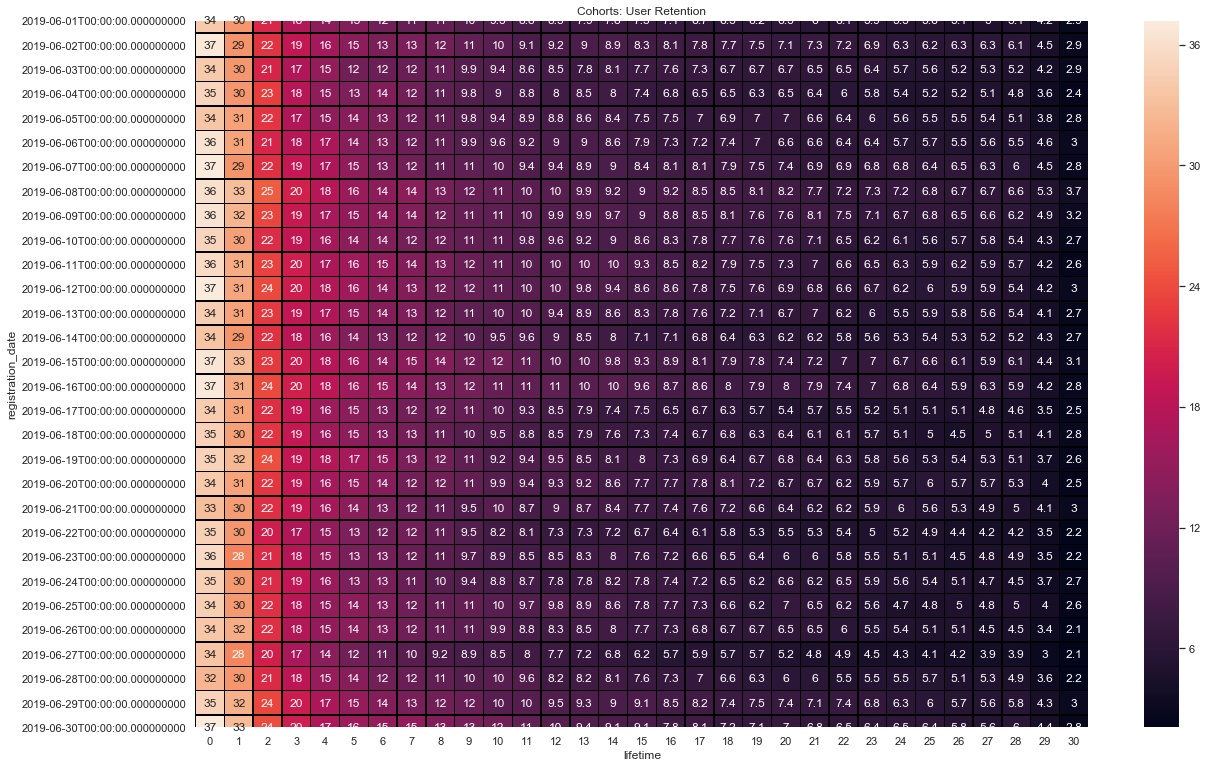

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white')
plt.figure(figsize=(20, 13))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, mask=retention_pivot.isnull(), annot=True, linewidths=0.5, linecolor='black')

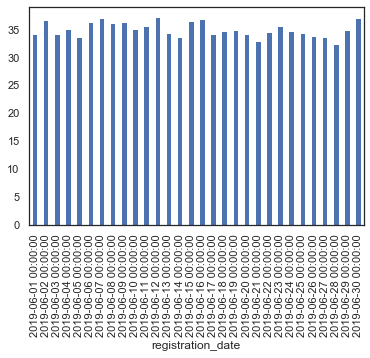

In [18]:
retention_pivot[0].plot.bar()

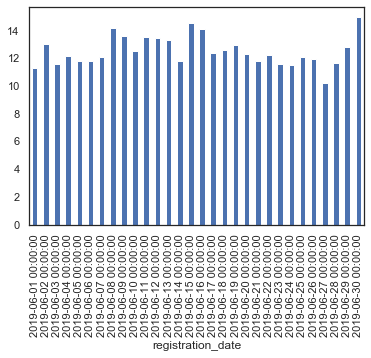

In [19]:
retention_pivot[7].plot.bar()

In [20]:
retention_pivot[7]['2019-06-30']/retention_pivot[7]['2019-06-01']

1.3244076718481195

### ARPU

In [21]:
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue = pd.DataFrame(getRevenue())

In [22]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 4 columns):
date                        833 non-null object
registration_date           833 non-null object
users_count_with_revenue    833 non-null int64
revenue                     833 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.2+ KB


In [23]:
for col in ['date','registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])

In [24]:
revenue.head()

,date,registration_date,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1082,1611.860
1,2019-06-02,2019-06-01,928,317.738
2,2019-06-02,2019-06-02,1257,1305.220
3,2019-06-03,2019-06-01,623,192.273
4,2019-06-03,2019-06-02,1008,554.859


In [25]:
revenue['revenue'].sum()

79685.865447

In [26]:
registered_users_count['registered_users_count'].sum()

100423

In [27]:
revenue['revenue'].sum()/registered_users_count['registered_users_count'].sum()

0.7935021404160402

In [28]:
revenue = revenue.rename(columns={'date':'activity_date'})

In [29]:
retention_table_with_revenue = retention_table.merge(revenue,on=['registration_date','activity_date'],how='left')

In [30]:
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1651,4833,34.160977,0,1082.0,1611.860
1,2019-06-02,2019-06-01,1429,4833,29.567556,1,928.0,317.738
2,2019-06-02,2019-06-02,1933,5255,36.784015,0,1257.0,1305.220
3,2019-06-03,2019-06-01,1021,4833,21.125595,2,623.0,192.273
4,2019-06-03,2019-06-02,1550,5255,29.495718,1,1008.0,554.859


In [31]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 0 to 929
Data columns (total 8 columns):
activity_date               930 non-null datetime64[ns]
registration_date           930 non-null datetime64[ns]
active_users_count          930 non-null int64
registered_users_count      930 non-null int64
retention_rate              930 non-null float64
lifetime                    930 non-null int32
users_count_with_revenue    833 non-null float64
revenue                     833 non-null float64
dtypes: datetime64[ns](2), float64(3), int32(1), int64(2)
memory usage: 61.8 KB


In [32]:
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue[col] = retention_table_with_revenue[col].fillna(0)

In [33]:
retention_table_with_revenue['users_count_with_revenue'] = retention_table_with_revenue['users_count_with_revenue'].astype(int)

In [34]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 0 to 929
Data columns (total 8 columns):
activity_date               930 non-null datetime64[ns]
registration_date           930 non-null datetime64[ns]
active_users_count          930 non-null int64
registered_users_count      930 non-null int64
retention_rate              930 non-null float64
lifetime                    930 non-null int32
users_count_with_revenue    930 non-null int32
revenue                     930 non-null float64
dtypes: datetime64[ns](2), float64(2), int32(2), int64(2)
memory usage: 58.1 KB


In [35]:
retention_table_with_revenue['arpu'] = retention_table_with_revenue['revenue'] / retention_table_with_revenue['active_users_count'] 

### A9.2.5

In [36]:
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue,arpu
0,2019-06-01,2019-06-01,1651,4833,34.160977,0,1082,1611.860,0.976293
1,2019-06-02,2019-06-01,1429,4833,29.567556,1,928,317.738,0.222350
2,2019-06-02,2019-06-02,1933,5255,36.784015,0,1257,1305.220,0.675230
3,2019-06-03,2019-06-01,1021,4833,21.125595,2,623,192.273,0.188318
4,2019-06-03,2019-06-02,1550,5255,29.495718,1,1008,554.859,0.357974


In [43]:
arpu_pivot = retention_table_with_revenue.pivot_table(index='registration_date',columns='lifetime',values='arpu')
arpu_pivot.head(10)

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,0.976293,0.222350,0.188318,0.090474,0.056714,0.215960,0.686825,0.323516,0.000000,0.061368,...,0.058239,0.489990,0.210142,0.021039,0.043126,0.171568,0.769008,0.128948,0.027442,0.403106
2019-06-02,0.675230,0.357974,0.213420,0.126478,0.052536,0.213401,0.083839,0.283805,0.076447,0.215764,...,0.022516,0.022901,0.098184,0.050143,0.805546,0.065083,0.011850,0.054992,0.029301,0.596368
2019-06-03,0.717116,0.243213,0.043576,0.126431,0.093071,0.437531,0.074710,0.057345,0.060045,0.070161,...,0.178001,0.048150,0.322848,0.020926,0.044762,0.051013,0.000000,0.000000,0.034498,0.000000
2019-06-04,0.570125,0.280646,0.156369,0.249738,0.207717,0.313095,0.196367,0.107556,0.201097,0.535641,...,0.036031,0.218364,0.000000,0.035660,0.015292,0.050697,0.000000,0.360193,0.000000,0.050684
2019-06-05,0.678426,0.053987,0.524198,0.164261,0.200625,0.003562,0.066171,0.133804,0.119720,0.465517,...,0.077189,0.039368,0.065654,0.278710,0.040788,0.313618,0.131072,0.363810,0.193209,0.246925
2019-06-06,0.864330,0.156215,0.295781,0.367368,0.192799,0.059184,0.268414,0.059151,0.038135,0.145965,...,0.215097,0.031984,0.108535,0.018374,0.153387,0.303742,0.598917,0.103838,0.101861,0.000000
2019-06-07,0.488339,0.439912,0.276970,0.192135,0.182919,0.572635,0.119355,0.149861,0.071297,0.174512,...,0.131543,0.045359,0.000000,0.114296,0.283932,0.036038,0.125212,1.156721,0.075919,0.067893
2019-06-08,0.653629,0.415474,0.192290,0.268525,0.276235,0.334379,0.235961,0.051926,0.131110,0.264527,...,0.093310,0.000000,0.213927,0.000000,0.084135,0.142929,0.146605,0.000000,0.788146,0.078673
2019-06-09,0.910159,0.186660,0.207617,0.137292,0.441263,0.104410,0.246871,0.360654,0.083993,0.102356,...,0.062687,0.000000,0.028893,0.067952,0.018327,0.041019,0.183464,0.000000,0.016263,0.000000


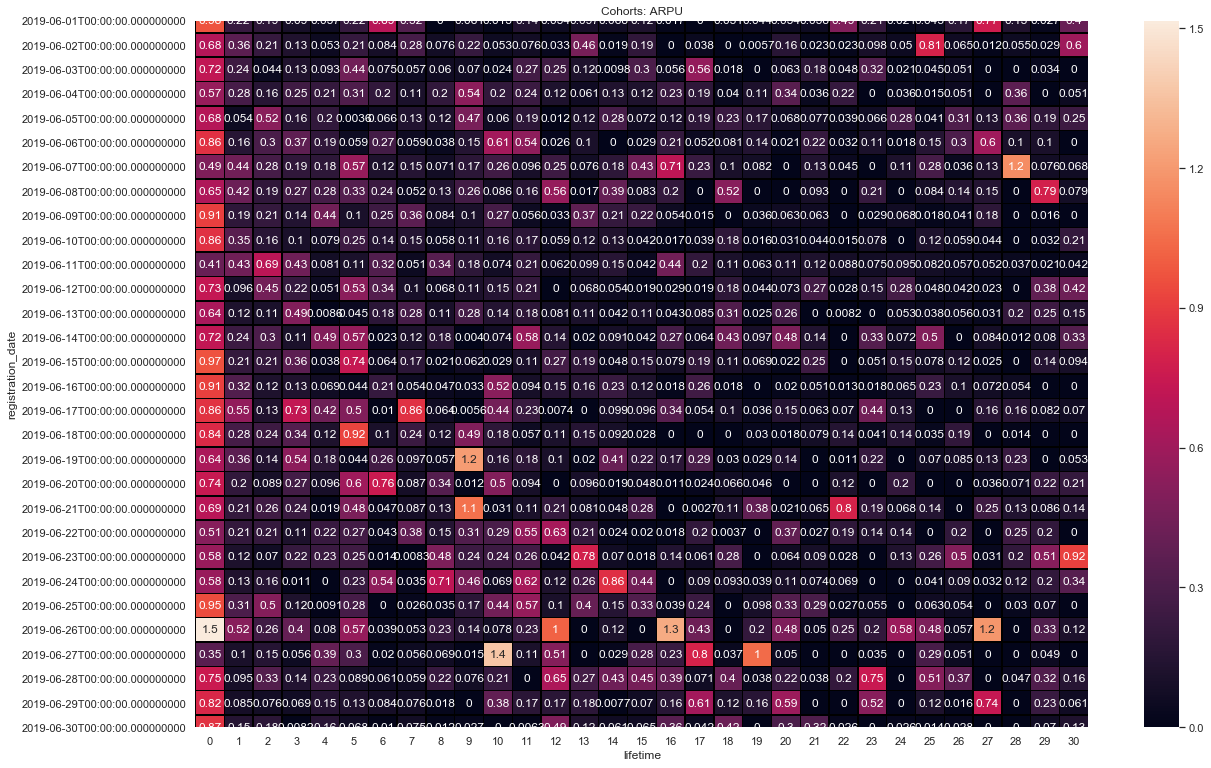

In [38]:
sns.set(style='white')
plt.figure(figsize=(20, 13))
plt.title('Cohorts: ARPU')
sns.heatmap(arpu_pivot, mask=retention_pivot.isnull(), annot=True, linewidths=0.5, linecolor='black')

#### Вывод по тепловой карте:
Можно наблюдать (в среднем) наибольшие значения ARPU на 0 день для каждой когорты пользователей.

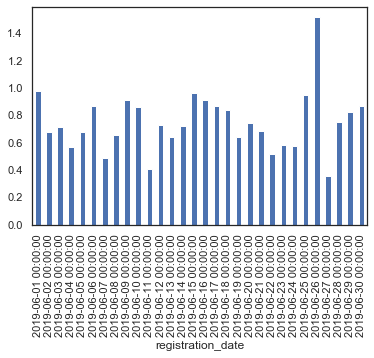

In [39]:
arpu_pivot[0].plot.bar()

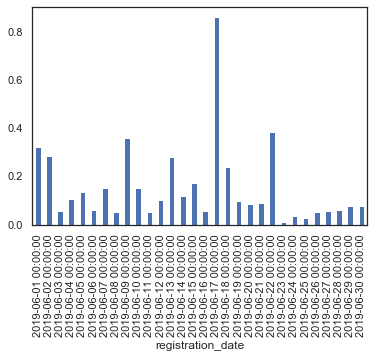

In [40]:
arpu_pivot[7].plot.bar()

#### Вывод по столбчатым графикам:
Можно наблюдать низкую зависимость ARPU от даты: резкие повышения ARPU схожи с выбросами.

In [41]:
#средний ARPU по когортам в зависимости от времени жизни пользователя
arpu_avg_pivot = retention_table_with_revenue.pivot_table(columns='lifetime',values='arpu')
arpu_avg_pivot.head()

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
arpu,0.748997,0.247612,0.231219,0.226372,0.161454,0.308641,0.175224,0.153147,0.140943,0.234994,...,0.094581,0.099685,0.144491,0.091224,0.153679,0.108511,0.161853,0.124374,0.150843,0.162709


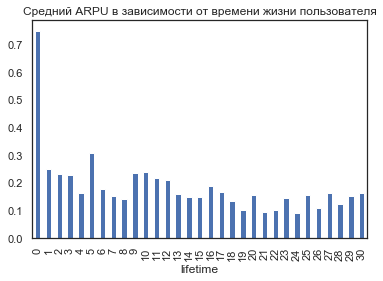

In [42]:
arpu_avg_pivot.iloc[0].plot.bar(title = 'Средний ARPU в зависимости от времени жизни пользователя')

#### Вывод по столбчатому графику:
Можно наблюдать резкое снижение ARPU после 0 дня жизни, после 1 дня до конца месяца ARPU меняется незначительно (к концу июня можно наблюдать небольшое снижение).